In [1]:
# Standard imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# Hugging Face Hub import

# Diffusers-specific imports
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Custom modules
from models import UNETLatentEdgePredictor, SketchSimplificationNetwork
from pipeline import SketchGuidedText2Image


c:\Users\zaccu\OneDrive\Documents\GitHub\U-SketchPlus\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# Configure and load sketch simplification network 

sketch_simplifier = SketchSimplificationNetwork().to(device)
sketch_simplifier.load_state_dict(torch.load("models-checkpoints/model_gan.pth"))

sketch_simplifier.eval()
sketch_simplifier.requires_grad_(False)

C:\Users\zaccu\AppData\Local\Temp\ipykernel_5216\1103916148.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sketch_simplifier.load_state_dict(torch.load("models-checkpoi

SketchSimplificationNetwork(
  (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU()
  (18): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): ReLU()
  (20): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [4]:
# Load Stable Diffusion Pipeline
stable_diffusion_1_5 = "benjamin-paine/stable-diffusion-v1-5"

In [5]:
stable_diffusion=StableDiffusionPipeline.from_pretrained(
    stable_diffusion_1_5,
    torch_dtype=torch.float16,
    safety_checker=None  # Skip the safety checker if it's not required
)
vae = stable_diffusion.vae.to(device)
unet = stable_diffusion.unet.to(device)
tokenizer = stable_diffusion.tokenizer
text_encoder = stable_diffusion.text_encoder.to(device) 

vae.eval()
unet.eval()
text_encoder.eval()

text_encoder.requires_grad_(False)
unet.requires_grad_(False)

Loading pipeline components...:  17%|█▋        | 1/6 [00:01<00:06,  1.27s/it]c:\Users\zaccu\OneDrive\Documents\GitHub\U-SketchPlus\.venv\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing it

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [6]:
# Load U-Net latent edge predictor
checkpoint = torch.load("models-checkpoints/unet_latent_edge_predictor_checkpoint.pt",map_location=torch.device('cpu'))

LEP_UNET = UNETLatentEdgePredictor(9320, 4, 9).to(device)
LEP_UNET.load_state_dict(checkpoint["model_state_dict"])

LEP_UNET.eval()
LEP_UNET.requires_grad_(False)

C:\Users\zaccu\AppData\Local\Temp\ipykernel_5216\323835721.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models-checkpoints/unet_latent_edge_p

UNETLatentEdgePredictor(
  (e1): encoder_block(
    (conv): convolutional_block(
      (conv1): Conv2d(9320, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): convolutional_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (

In [7]:
import numpy 
# Set Scheduler
noise_scheduler = DDIMScheduler(
        beta_start = 0.00085,
        beta_end = 0.012,
        beta_schedule = "scaled_linear",
        num_train_timesteps = 1000,
        clip_sample = False,
    )

In [8]:
import numpy
print(numpy.__version__)

1.26.4


In [9]:
# Initialize Text-guided Text-to-Image synthesis pipeline

pipeline = SketchGuidedText2Image(stable_diffusion_pipeline = stable_diffusion, 
                                  unet = unet, vae = vae, 
                                  text_encoder = text_encoder, 
                                  lep_unet = LEP_UNET, scheduler = noise_scheduler, 
                                  tokenizer = tokenizer,
                                  sketch_simplifier = sketch_simplifier,
                                  device = device)

Original Edge Maps - Simplified Edge Maps



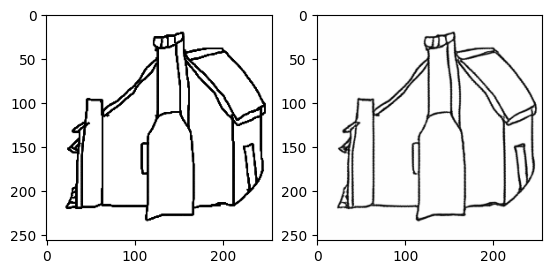

Would you like to keep the simplified edge maps? [Y]\[N]



100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


In [21]:
edge_maps = [Image.open("example-sketches/Sketch188.png")]
seed = 1000

inverse_diffusion = pipeline.Inference(
    prompt=["Bike"],
    num_images_per_prompt=1,
    edge_maps=edge_maps,
    negative_prompt=None,
    num_inference_timesteps=50,
    classifier_guidance_strength=8,
    sketch_guidance_strength=1.6,
    seed=seed,
    simplify_edge_maps=True,
    guidance_steps_perc=0.5,
)

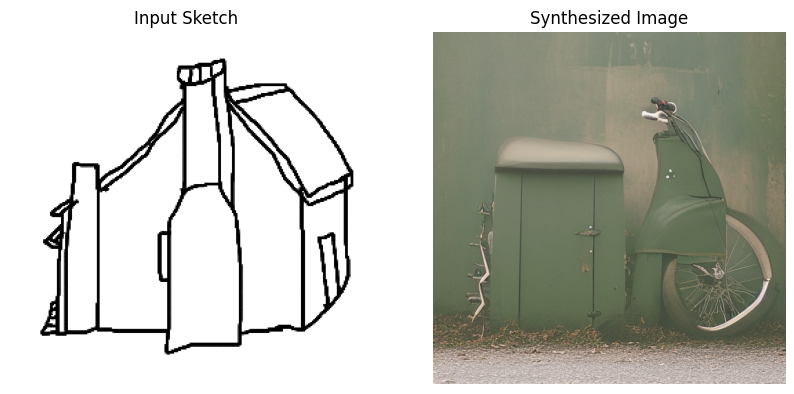

In [22]:
for edge_map, image in zip(edge_maps, inverse_diffusion["generated_image"]):
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    axs[0].imshow(edge_map)
    axs[1].imshow(image)
    axs[0].axis("off")
    axs[1].axis("off")
    axs[0].set_title("Input Sketch")
    axs[1].set_title("Synthesized Image")